# Computation of time increment for a vertex

We first look at the tent pitching algorithm, then focus on how to correctly compute a time increment for a vertex.

## Tent pitching algorithm

### Initialization
* let the `wavespeed` ($\overline{c}$) and `slabheight` be given.
* Let `tau` be the collection of current times for each vertex,
    initially all zero
* Let `edgedts` be a collection of reference heights (dt values) for each edge.  These are computed by dividing the length of the edge by the wavespeed.
* Let `vertdts` be a collection of reference heights (dt values) for each
    vertex.  These are computed as the minimum of `edgedts` for all edges adjacent to the vertex.
* Let `ktilde` be a collection of the current planned heights (dt values) for each vertex.  Initially this is a copy of `vertdts`
* Let `ready_vs` be a collection of vertices for which good
    progress can be made.
* Let `vs_level` be the collection containing the level (layer) for each
    vertex (initially zero for each vertex).

### Main Loop (current implementation)

while `ready_vs` is not an empty collection, perform the following steps:

* Set minlevel to a large value.
* Choose a tent vertex `vert` with minimal level (layer) and remove it from the `ready_vs` collection.  It will be the central vertex for the tent.
* Update `minlevel` to the level of the vertex chosen.
* Construct the tent with 
   * bottom time `tent.tbot` equal to its `tau` value
   * top time `tent.ttop` equal to:
     min{`slabheight`, `tent.tbot` + `ktilde[vert]`},
   * level equal to the central `vert`'s `vs_level` value.
   * neighbor vertices
   * neighbor times
* Append the new tent to the slab collection.
* Update the value of `tau` for the selected vertex to the `tent.ttop` time.
* Update the levels of the neighbor vertices to be one more than the tent's level in `vs_level`.
* *KEY STEP:* Update the `ktilde` value for each neighbor vertex that hasn't reached the final slab time. This is currently done by computing the differences in `tau` values between the neighbor vertex and each of its neighbors, then adding the edge time (edge length/wavespeed).  That is, letting $v_0$ be the neighbor vertex and $v_i$ one of its neighbor vertices:
  $$\tilde{k} = \min \{ dt_i : v_i \text{ is adjacent to } v_0 \}$$
  where 
  $$dt_i = \tau(v_i) - \tau(v_0) + \frac{\| v_i - v_0 \|}{\overline{c}}$$
  Note: This is exactly the same method used to compute `vertdts` and `ktilde` in the initialization section above.

* If such a vertex is not in `ready_vs`, but is now considered to be able to make good progress (i.e. its `ktilde` is more than half its `vertdts` reference value), add it to `ready_vs`.


### Computation of $\tilde{k}$ in 2D (two spatial dimensions) for a unit simplex spatial element

The correct computation of $\tilde{k}$ is necessary to preserve the invariant: $\| \nabla \tau \| \le \frac{1}{\overline{c}}$.  Let us call the method above "dt_minvert", since it computes a $\tilde{k}$ value as the minimum of vertex times.  This method works in 1D, but fails to preserve the invariant in 2D.  We'll see why and take a look at two other methods

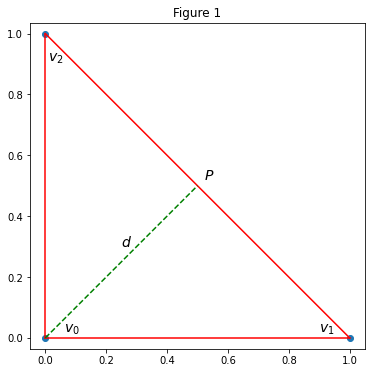

In [1]:
def vertsedges(verts, closestpt=False, labels=False, title="Figure"):
    import matplotlib.pyplot as plt
    edges = []
    for i, v in enumerate(verts):
        edges.append([v, verts[(i+1)%len(verts)]])
    fig = plt.figure(figsize=[6,6])
    ax = fig.add_subplot(111)
    plt.axis('equal')
    xs, ys = zip(*verts)
    for e in edges:
        ax.plot(*list(zip(*e)), color='red')
    if closestpt:
        ax.plot([0,0.5], [0,0.5], color='green', linestyle='dashed')
    ax.scatter(xs, ys)
    if labels:
        ax.text(0.06,0.02,"$v_0$", fontsize=14)
        ax.text(0.9,0.02,"$v_1$", fontsize=14)
        ax.text(0.01,0.91,"$v_2$", fontsize=14)
        ax.text(0.52,0.52,"$P$", fontsize=14)
        ax.text(0.25,0.3,"$d$", fontsize=14)
    plt.title(title)
verts = [(0,0), (1,0), (0,1)]
vertsedges(verts, True, True, "Figure 1");

Consider the spatial element shown in Figure 1.  Its vertices are given as $v_0, v_1,$ and $v_2$.  Suppose that we would like to compute a $\tilde{k}$ value for vertex $v_0$

Suppose that $\overline{c} = 1$ and $\tau(v_j)=0,\ \ j=0,1,2$.  

The "dt_minvert" method computes $dt=1$ with respect to both $v_1$ and $v_2$ yielding $\tilde{k} = 1$, but $\| \nabla \tau \| = \sqrt{2}$ so the method fails to preserve the invariant.

Let us consider a second method which we will call "dt_interp" since it requires computing an interpolated (or possibly extrapolated) value for $\tau(P)$ where $P$ is the point on the line of the facet (edge) opposite $v_0$ which is closest to $v_0$ (see Figure 1).  In this method, we compute $\tilde{k}(v_0)$ as follows:

$$\tilde{k} = \min \{ dt_i : f_i \text{ is a facet opposite to } v_0 \}$$
$$dt_i = \tau(P_i) - \tau(v_0) + \frac{d_i}{\overline{c}}$$
where $d_i$ is the distance from $v_0$ to facet $f_i$ and $\tau(P_i)$ is computed (once $P_i$ has been determined) by interpolation as follows:

$$\tau(P_i) = \tau(v_{i1}) + \frac{\|P_i - v_{i1} \|}{\| v_{i2} - v_{i1} \|}(\tau(v_{i2}) - \tau(v_{i1}))$$

In this simple example, $v_0$ has only one opposite facet, and by inspection we find that 
$$P = (0.5, 0.5),\\ \tau(P) = 0.5 \tau(v_1) + 0.5 \tau(v_2) = 0, \\d = \frac{\sqrt{2}}{2} \\
\tilde{k} = dt = 0 - 0 + \frac{\sqrt{2}}{2}$$
This is the correct value for $\tilde{k}$ since now we compute $\| \nabla \tau \| = 1$

Now let us repeat the previous example, but with $\tau(v_1) = 0.5$ and $\tau(v_2) = 0.1$

This time we obtain 
$$\tau(P) = 0.5 + 0.5(0.1 - 0.5) = 0.3 \\ \tilde{k} = dt = 0.3 - 0 + \frac{\sqrt{2}}{2} \approx 1.0071$$

If we use this value of $\tilde{k}$, will $\| \nabla \tau \| = 1.0$ as we hope?  Surprisingly, the answer is that it does not.  With $\tilde{k} = 1.0071$, we will have $\tau(v_0) = 1.0071$.  But the plane containing the three spacetime points $(v_0,\tau(v_0)), (v_1, \tau(v_1)), (v_2, \tau(v_2))$ has a constant gradient $\| \nabla \tau \| = 1.03923$ for spatial points in this element.  We can run some tests to find out more.

In addition to functions for "dt_minvert" and "dt_interp" methods, we add a function for a new super-secret method called "dt_correct".  We also add a helper to compute the norm of the gradient of a plane from three 3D points, where each point is of the form $(x, y, t)$.

In [2]:
import numpy as np
import numpy.linalg as la


def compute_normgrad2D(pts):
    """
    Given a list of three spacetime points, compute the normal
    to the plane they lie in and its gradient
    """
    m20, m21, m22, V = A2m2D(pts)
    a = la.det(m20)
    b = - la.det(m21)
    c = la.det(m22)
    normgrad = np.sqrt((a*a + b*b)/(c*c))
    checknormal = V@np.array([a, b, c])
    nmlnorm = la.norm(checknormal)
    assert nmlnorm < 1.0e-15, "normal is orthogonal to plane"
    return normgrad


def dt_minvert(pts, cbar):
    """
    INPUTS

    pts: the spacetime coordinates of the central vertex and those
         of the vertices of an opposite facet (edge),
    cbar: the wavespeed

    Returns a time increment for the central vertex
    """
    V = np.roll(pts, -1, 0) - pts
    dt = min((V[0, 2] + np.sqrt(V[0, 0]**2 + V[0, 1]**2)/cbar,
              V[2, 2] + np.sqrt(V[2, 0]**2 + V[2, 1]**2)/cbar))
    return dt


def dt_interp(pts, cbar):
    """
    INPUTS

    pts: the spacetime coordinates of the central vertex and those
         of the vertices of an opposite facet (edge),
    cbar: the wavespeed

    Returns a time increment for the central vertex
    """

    _, _, m22, V = A2m2D(pts)
    x21, y21 = V[1, 0], V[1, 1]
    # norm squared of w21 (see last cell)
    w21sq = x21**2 + y21**2
    # \gamma
    ga = la.det(m22) / w21sq
    # the minimum distance from v0 to the line of the facet (edge) containing v1 and v2
    d = ga * np.sqrt(w21sq)
    # initial tau(v0), tau(v1)
    t0, t1 = pts[0, -1], pts[1, -1]
    # interpolate to get tau(P)
    tp = t1 + np.sqrt(((ga*V[1, 1] - V[0, 0])**2 +
                       (ga*V[1, 0] + V[0, 1])**2)/w21sq) * V[1, 2]
    # get dt for vertex v0
    dt0 = tp - t0 + d/cbar
    return dt0


def dt_correct(pts, cbar):
    """
    INPUTS

    pts: the spacetime coordinates of the central vertex and those
         of the vertices of an opposite facet (edge),
    cbar: the wavespeed

    Returns the optimal time increment for the central vertex
    """
    m20, m21, m22, _ = A2m2D(pts)
    al0 = - m20[1, 0]
    al1 = + m20[0, 0] * m20[1, 1]
    be0 = + m21[1, 0]
    be1 = - m21[0, 0] * m21[1, 1]
    c = la.det(m22)
    d0sq = al0*al0 + be0*be0
    d1sq = al1*al1 + be1*be1
    d10 = al0*al1 + be0*be1
    trm1 = d10/d0sq
    trm2 = (d1sq - (c/cbar)**2)/d0sq
    disc = trm1*trm1 - trm2
    t0, t1 = pts[0, -1], pts[1, -1]
    if disc < 0:
        # This means that there is no value for t10 that can make the norm
        # of the gradient equal to 1/c̅.  This can happen only if
        # previously-pitched tents have faces which exceed this gradient.
        # This can happen when the wavespeed increases with time.
        # The reasonable response is to set dt = 0 for the vertex.
        dt0 = 0
        print("No optimal dt. Set dt = 0")
    else:
        t10 = -trm1 - np.sqrt(disc)
        dt0 = (t1 - t10 - t0)
    return dt0


def A2m2D(A):
    """
    Get matrix of point differences and minor matrices
    """
    V = A[1:, :] - A[:-1, :]
    return V[:, [1, 2]], V[:, [0, 2]], V[:, [0, 1]], V


def test(func, pts, cbar):
    """
    Test a function with the provided points and wavespeed
    """
    ptscpy = pts.copy()
    print("test using method {}".format(func.__name__))
    dt = func(ptscpy, cbar)
    print("computed dt = ", dt)
    ptscpy[0,2] += dt 
    print("checking norm of grad(tau) for vertices")
    print(ptscpy)
    gradnorm = compute_normgrad2D(ptscpy)
    print("norm of grad(tau)", gradnorm)
    print("1/cbar", 1./cbar)
    if gradnorm > 1/cbar:
        print("Norm of grad tau exceeds 1/cbar! Invariant fails!")
    elif gradnorm == 1/cbar:
        print("Correct!")
    else:
        print("Norm of grad tau is less than 1/cbar.  Too conservative.")
    print("finished test using method {}".format(func.__name__))
    print()

In [3]:
verts1 = np.array([[0, 0, 0], [1, 0, 0.0], [0, 1, 0.0]])
verts2 = np.array([[0, 0, 0], [1, 0, 0.5], [0, 1, 0.1]])
verts3 = np.array([[0, 0, 0], [.8, 0.2, 0.0], [0.2, .7, 0.0]])
verts4 = np.array([[0, 0, 0.2], [.8, 0.2, 0.5], [0.2, .7, 0.1]])
title1 = "TEST 1: Unit simplex, all times zero"
title2 = "TEST 2: Unit simplex, times different"
title3 = "TEST 3: non-unit simplex, all times zero"
title4 = "TEST 4: non-unit simplex, times different"

def testall(cbar=1.0):
    """
    Run some test cases using specified spacetime vertices
    """
    tests = [(title1, verts1), (title2, verts2), (title3, verts3), (title4, verts4)]
    for t in tests:
        title, verts = t
        print('*'*len(title))
        print(title)
        print('*'*len(title))
        print("vertices:")
        for i, row in enumerate(verts):
            print("V{} = {}".format(i, row))
        print()

        for func in [dt_minvert, dt_interp, dt_correct]:
            test(func, verts, cbar)


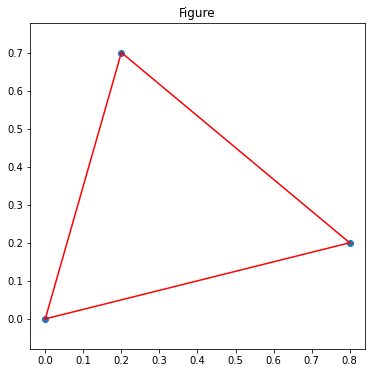

In [4]:
vertsedges([[v[0],v[1]] for v in verts3])

In [46]:
testall()

************************************
TEST 1: Unit simplex, all times zero
************************************
vertices:
V0 = [0. 0. 0.]
V1 = [1. 0. 0.]
V2 = [0. 1. 0.]

test using method dt_minvert
computed dt =  1.0
checking norm of grad(tau) for vertices
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
norm of grad(tau) 1.4142135623730951
1/cbar 1.0
Norm of grad tau exceeds 1/cbar! Invariant fails!
finished test using method dt_minvert

test using method dt_interp
computed dt =  0.7071067811865476
checking norm of grad(tau) for vertices
[[0.         0.         0.70710678]
 [1.         0.         0.        ]
 [0.         1.         0.        ]]
norm of grad(tau) 1.0
1/cbar 1.0
Correct!
finished test using method dt_interp

test using method dt_correct
computed dt =  0.7071067811865476
checking norm of grad(tau) for vertices
[[0.         0.         0.70710678]
 [1.         0.         0.        ]
 [0.         1.         0.        ]]
norm of grad(tau) 1.0
1/cbar 1.0
Correct!
finished test using met

### Implementation of "dt_interp"

The "dt_interp" method is implemented above for an arbitrary $v_0, v_1, v_2$ as follows:

For each facet $f$, 

$$dt = \tau(P) - \tau(v_0) + \frac{d}{\overline{c}}$$

for simplicity, we omit facet subscripts in the following.

$$\tau(P) = \tau(v_{1}) + \frac{\|P - v_{1} \|}{\| v_{2} - v_{1} \|}(\tau(v_{2}) - \tau(v_{1}))$$

To find $P$, note that $P = v_0 + \hat{n}d$ for a unit vector $\hat{n}$ orthogonal to the edge connecting $v_{1}$ and $v_{2}$.

Let 
$$\mathbf{w}_{10} = v_1 - v_0 = \langle x_{10}, y_{10} \rangle, \ \text{ where } x_{10} = x_1 - x_0, y_{10} = y_1 - y_0$$
$$\mathbf{w}_{21} = v_2 - v_1 = \langle x_{21}, y_{21} \rangle, \ \text{ where }  x_{21} = x_2 - x_1, y_{21} = y_2 - y_1$$
We can compute $\hat{n}$ as
$$\hat{n} = \frac{\langle y_{21}, -x_{21} \rangle}{\| \mathbf{w}_{21} \|} $$
Let 
$$\gamma = \frac{d}{\| \mathbf{w}_{21} \|} \text{ so } P = v_0 + \gamma \langle y_{21}, -x_{21} \rangle$$
Then
$$\tau(P) = \tau(v_1) + \frac{\|\gamma \langle y_{21}, -x_{21} \rangle - \mathbf{w}_{10} \|}{\| \mathbf{w}_{21} \|}(\tau(v_2) - \tau(v_1))$$
In two spatial dimensions,
$$ d= \frac{\| \mathbf{w}_{10} \times \mathbf{w}_{21} \|}{\| \mathbf{w}_{21} \|} \text{ so } 
\gamma = \frac{\| \mathbf{w}_{10} \times \mathbf{w}_{21} \|}{\| \mathbf{w}_{21} \|^2}$$

The minimum distance $d$ can also be computed by creating an H1 finite element space from the mesh and using the dshape function provided by each element to obtain $1/d$.  This would work in any dimension. In 3D, the interpolation to obtain $\tau(P)$ would require computing the equation of the plane containing the vertices of the opposite facet (face).